In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.datasets import load_iris

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score 
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, TunedThresholdClassifierCV, FixedThresholdClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import balanced_accuracy_score

from sklearn.utils.validation import column_or_1d

import sklearn
#pip install --upgrade scikit-learn
sklearn.__version__


'1.7.1'

In [2]:
#pip install --upgrade scikit-learn

**Загрузим данные и сделаем задачу бинарной классификации**

In [3]:
# from sklearn.datasets import fetch_openml
# X, y_cat = fetch_openml(data_id=1464, return_X_y=True, parser='auto')
X = pd.read_csv('dataset/data_id_1464_X.csv')
y_cat = pd.read_csv('dataset/data_id_1464_y_cat.csv')
y = np.where(y_cat==1,0,1).reshape(-1) # КОНТРОЛЬ РАЗМЕРНОСТИ, нужен всегда список
y

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [4]:
X.describe()

,V1,V2,V3,V4
count,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086
std,8.095396,5.839307,1459.826781,24.376714
min,0.000000,1.000000,250.000000,2.000000
25%,2.750000,2.000000,500.000000,16.000000
50%,7.000000,4.000000,1000.000000,28.000000
75%,14.000000,7.000000,1750.000000,50.000000
max,74.000000,50.000000,12500.000000,98.000000


In [5]:
np.array(y).mean()

0.23796791443850268

Сплитуем данные и отложим тестовый набор. Так как данных мало стратифицируем.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, 
                                                     test_size=0.3, stratify=y)

In [7]:
print(np.mean(y_train), np.mean(y_test))

0.23709369024856597 0.24


In [8]:
len(y_test)

225

## Построим построим базовый контейнер для исходной -`origin` модели

In [9]:
model_origin = make_pipeline(StandardScaler(), LogisticRegression())
model_origin

,steps,"[('standardscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


## Валидация модели `origin`

Так как данных не слишком много, а хочетстся понадежнее поработать с валидацией используем `RepeatedStratifiedKFold` для повторного прохождения на уникальных фолдах.

In [10]:
scoring = ["accuracy", "balanced_accuracy"]
cv_scores = [
    "train_accuracy",
    "test_accuracy",
    "train_balanced_accuracy",
    "test_balanced_accuracy",
]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
cv_results_model_origin = pd.DataFrame(
    cross_validate(
        model_origin,
        X_train,
        y_train,
        scoring=scoring,
        cv=cv,
        return_train_score=True,
        return_estimator=True,
    )
)
cv_results_model_origin[cv_scores].agg(["mean", "std"]).T

,mean,std
train_accuracy,0.773184,0.006625
test_accuracy,0.769223,0.018808
train_balanced_accuracy,0.545707,0.015395
test_balanced_accuracy,0.541715,0.029941


## Поиск оптимального порога

In [11]:
model_tuned = TunedThresholdClassifierCV(estimator=model_origin, scoring="balanced_accuracy")
cv_results_model_tuned = pd.DataFrame(
    cross_validate(
        model_tuned,
        X_train,
        y_train,
        scoring=scoring,
        cv=cv,
        return_train_score=True,
        return_estimator=True,
    )
)
cv_results_model_tuned[cv_scores].agg(["mean", "std"]).T

,mean,std
train_accuracy,0.677195,0.022884
test_accuracy,0.668458,0.049662
train_balanced_accuracy,0.689079,0.012382
test_balanced_accuracy,0.674181,0.042814


Кстати всего построено (моделей количество фолдов)$\times$(количество повторов) или `n_splits`$\times$`n_repeats`:

In [12]:
len(cv_results_model_tuned)

50

Лучший порог подобранный по отдельности для каждой модели

In [13]:
[est.best_threshold_ for est in cv_results_model_tuned["estimator"]][:10]

[0.2766295048131445,
 0.26294919104555226,
 0.26539672141738974,
 0.2831297471875591,
 0.2640206035750998,
 0.2482452700743794,
 0.24355647495358998,
 0.270024328857198,
 0.2489781515446935,
 0.29124156231340254]

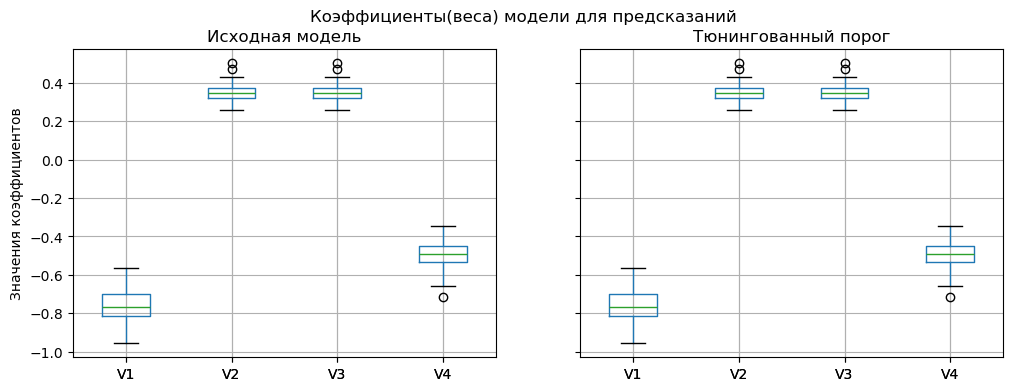

In [14]:
model_origin_coef = pd.DataFrame(
    [est[-1].coef_.ravel() for est in cv_results_model_origin["estimator"]],
    columns=X.columns,
)
model_tuned_coef = pd.DataFrame(
    [est.estimator_[-1].coef_.ravel() for est in cv_results_model_tuned["estimator"]],
    columns=X.columns,
)

fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharex=True, sharey=True)
model_origin_coef.boxplot(ax=ax[0])
ax[0].set_ylabel("Значения коэффициентов")
ax[0].set_title("Исходная модель")
model_tuned_coef.boxplot(ax=ax[1])
ax[1].set_title("Тюнингованный порог")
_ = fig.suptitle("Коэффициенты(веса) модели для предсказаний")

Обратите внимание **после тюнинга порога это одна и таже модель, коэффициенты не изменились!**

### Какой порог выбрать?

Важный вопрос к обсужению: 
- что такое мода и почему ее не найти в виде статистической функции, почему мы ищем максимум на pdf-функции.
- как надтянуть pdf-функцию на данные.

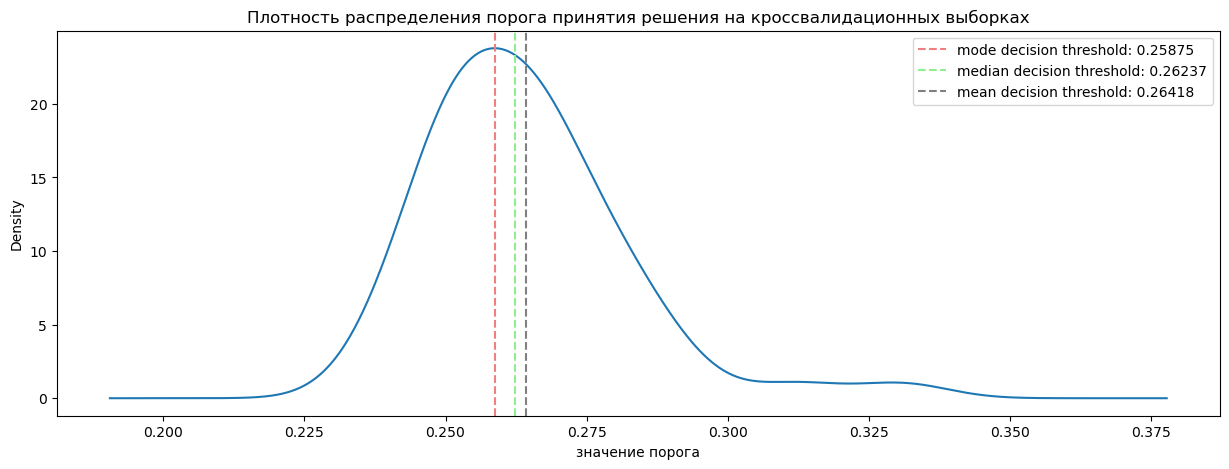

In [15]:
decision_threshold = pd.Series(
    [est.best_threshold_ for est in cv_results_model_tuned["estimator"]],
)

fig, ax = plt.subplots(figsize=(15,5))

ax = decision_threshold.plot.kde(bw_method=None) #bw_method=0.3 'scott', 'silverman',
line = ax.get_lines() # забрал список отрисованных линий
x_plt, y_plt = line[0].get_data() # из списка взял нужную линию для разборки по точкам 

ths = {
    'mode':   [x_plt[np.argmax(y_plt)],'lightcoral'],
    'median': [decision_threshold.median(), 'lightgreen'],
    'mean':   [decision_threshold.mean(),  'gray']
}

for key in ths.keys():
    ax.axvline(
        ths[key][0],
        color=ths[key][1],
        linestyle="--",
        label=f"{key} decision threshold: {ths[key][0]:.5f}",
    )

ax.set_xlabel("значение порога")
ax.legend(loc="upper right")
_ = ax.set_title(
    "Плотность распределения порога принятия решения на кроссвалидационных выборках"
)

(array([1., 2., 0., 1., 0., 4., 3., 2., 3., 2., 2., 3., 1., 2., 5., 1., 3.,
        2., 0., 3., 2., 0., 0., 2., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.23734475, 0.23921607, 0.24108739, 0.24295871, 0.24483002,
        0.24670134, 0.24857266, 0.25044398, 0.2523153 , 0.25418662,
        0.25605794, 0.25792925, 0.25980057, 0.26167189, 0.26354321,
        0.26541453, 0.26728585, 0.26915716, 0.27102848, 0.2728998 ,
        0.27477112, 0.27664244, 0.27851376, 0.28038507, 0.28225639,
        0.28412771, 0.28599903, 0.28787035, 0.28974167, 0.29161299,
        0.2934843 , 0.29535562, 0.29722694, 0.29909826, 0.30096958,
        0.3028409 , 0.30471221, 0.30658353, 0.30845485, 0.31032617,
        0.31219749, 0.31406881, 0.31594013, 0.31781144, 0.31968276,
        0.32155408, 0.3234254 , 0.32529672, 0.32716804, 0.32903935,
        0.33091067]),
 <BarContainer object of 50 artists>)

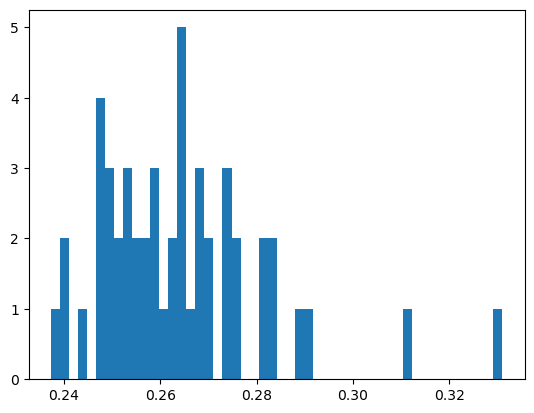

In [16]:
plt.hist(decision_threshold, bins=50)

In [17]:
ths_final = {
    'origin': 0.5,
    'mode':   x_plt[np.argmax(y_plt)],
    'median': decision_threshold.median(),
    'mean':   decision_threshold.mean(),
}
comparison =pd.DataFrame()
for key in ths_final:
    final_tune = FixedThresholdClassifier(model_origin, threshold=ths_final[key]).fit(X_train, y_train)
    comparison.loc[key,'train']= balanced_accuracy_score(y_train, final_tune.predict(X_train))
    comparison.loc[key,'test'] = balanced_accuracy_score(y_test, final_tune.predict(X_test))

comparison.sort_values(by='test')

,train,test
origin,0.545173,0.537524
mode,0.693730,0.729045
median,0.692204,0.731969
mean,0.692204,0.731969


In [18]:
decision_threshold.median()

0.2623720587466354

In [19]:
decision_threshold.mean()

0.26417707881545355